In [9]:
import numpy as np
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp

In [10]:
from casadi import *

In [11]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return x_n 
        
        

### AAC dynamics test

In [12]:
dt = 0.02
simTime = 20

p0 = 0
v0 = 20
z0 = 100

v_ego = 14
v_des = 24
m  = 1650
g = 9.81
f0 = 0.25
f1 = 5
f2 = 0.1
c_a = 0.3
c_d = 0.3
T = 1.8

aac = AAC(m, c_d, f0, f1, f2, v_ego)
t = 0
x = np.array([p0,v0,z0])

Fr = f0 * v0**2 + f1 * v0 + f2
u = Fr

xf = aac.update(x, u, t, dt)


In [13]:
class QPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1]        
        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1]
        z = symb_x[2]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        
    def lf_clf(self, x):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        return -2/self.m * Fr*(v-self.v_des)
        
    def lg_clf(self, x):
        v = x[1]
        z = x[2]
        
        return 2/m*(v - self.v_des)
        
    def lf_cbf(self, x):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        return self.Th/self.m*Fr + self.v_ego - v
    
    def lg_cbf(self, x):
        return -self.Th/self.m
        
    def compute_controller(self, x, u_ref):
        v = x[1]
        z = x[2]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, dB + self.cbf_rate * B)
        
                
        #LfV = self.lf_clf(x)
        #LgV = self.lg_clf(x);
        
        #LfB = self.lf_cbf(x);
        #LgB = self.lg_cbf(x);
        
        #vertcat(-LfV - LgV * u - self.clf_rate * V,
              #      LfB + LgV * u + self.cbf_rate * B)
           
        #print(gqp)

        #G = np.array([[LgV], [-LgB]])
        
        #h = np.array([[-LfV - self.clf_rate * V],
        #              [LfB + self.cbf_rate * B]])    
        
              
        #weight_input = 2/self.m**2;
        
        #P = weight_input;
        #q = -weight_input * u_ref;
        
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        S = qpsol('S', 'qpoases', qp,{'verbose':False,'print_time':False})
             

        r = S(lbg=0)
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        
        return k, slack_sol, V, B

### CBF-CLF-QP controller test

In [19]:
dt = 0.02
simTime = 20

p0 = 0.
v0 = 20.
z0 = 100.

x = [p0,v0,z0]

v_ego = 14
v_des = 24
m  = 1650
g = 9.81
f0_nom = 1
f1_nom = 1
f2_nom = 1
c_a = 0.3
c_d = 0.3
Th = 1.8
p_slack = 2e-2

clf_rate = 5
cbf_rate = 5

cont = QPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

Fr = f0_nom * v0**2 + f1_nom * v0 + f2_nom
u = Fr

k = cont.compute_controller(x, u)
print(k)



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.490949e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.863986e-01   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   
(6860.024390243925, 48.78048780487802, 16.0, 57.883792048929664)


In [51]:

dt = 0.02
simTime = 20

# Parametros reales
v_ego = 22
v_des = 30
m  = 1650.0
g = 9.81
f0 = 0.1
f1 = 5
f2 = 0.25
c_a = 0.3
c_d = 0.3
T = 1.8

# Parametros nominales
f0_nom = 0.1
f1_nom = 5
f2_nom = 0.25

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Sistema
aac = AAC(m, c_d, f0, f1, f2, v_ego)

# Controlador
cont = QPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

# Estado inicial
p0 = 0
v0 = 20
z0 = 60

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []
v_ego_lst = []

for t in np.arange(0, simTime, dt):
    # Get Fr
    v = x[1]
    Fr = f0_nom * v**2 + f1_nom * v + f2_nom
    
    # Control Input
    k, slack_sol, V, B = cont.compute_controller(x, Fr)
    
    if k< -5000:
        k = -5000
    elif k>5000:
        k = 5000
    
    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)
    #print('Fr: {} ,  k:{}, x: {}'.format(Fr,k,x))
          
    # Save data
    x_lst.append(x)
    u_lst.append(k)
    V_lst.append(V)
    B_lst.append(B)
    slack_lst.append(slack_sol)
    v_ego_lst.append(aac.v_ego)
    
    aac.v_ego += 0.5*np.random.uniform(low=-1, high=1)
    
    x = x_n
                 



####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.467336e-07   |   ADD CON    0   |     1   |     1   
       1   |   6.839502e-02   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.467569e-07   |   ADD CON    0   |     1   |     1   
       1   |   6.901418e-02   |   REM BND    0   |     0   |     1   
       2   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 --

       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.494222e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.120844e-01   |   REM BND    0   |     0   |     1   
       2   |   9.835575e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.494119e-07   |   ADD CON    0   |     1   |     1   
       1   |   2.112725e-01   |   REM BND    0   |     0   |     1   
       2   |   9.831409e-01   |   ADD CON    1   |     0   |     2   
       3

       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.479149e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.113306e-01   |   REM BND    0   |     0   |     1   
       2   |   8.965635e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.479041e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.108060e-01   |   REM BND    0   |     0   |     1   
       2   |   8.959722e-01   |   ADD CON    1   |     0   |     2   
       3

       1   |   8.148145e-02   |   REM BND    0   |     0   |     1   
       2   |   8.216480e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.471672e-07   |   ADD CON    0   |     1   |     1   
       1   |   8.119983e-02   |   REM BND    0   |     0   |     1   
       2   |   8.201764e-01   |   ADD CON    1   |     0   |     2   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.471582e-07   |   ADD CON    0   |     1   |     1   
       1

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454215e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.296188e-02   |   REM BND    0   |     0   |     1   
       2   |   1.534330e-03   |   ADD CON    1   |     0   |     2   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.453968e-07   |   ADD CON    0   |     1   |     1   
       1   |   1.905948e-02   |   ADD CON    1   |     0   |     2   
       2   |   2.707367e-02   |   REM CON    0   |     0   |     1   
       3   |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454018e-07   |   ADD CON    0   |     1   |     1   
       1   |   6.261036e-03   |   ADD CON    1   |     0   |     2   
       2   |   1.251674e-03   |   REM CON    0   |     0   |     1   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454255e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.809981e-05   |   REM BND    0   |     0   |     1   
       2   |   1.495430e-03   |   ADD CON    1   |     0   |     2   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter

       2   |   2.474924e-03   |   ADD CON    1   |     0   |     2   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454069e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.406352e-03   |   ADD CON    1   |     0   |     2   
       2   |   4.413694e-04   |   REM CON    0   |     0   |     1   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454306e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.092610e-05   |   REM BND    0   |     0   |     1   
       2

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454163e-07   |   ADD CON    0   |     1   |     1   
       1   |   3.381462e-03   |   ADD CON    1   |     0   |     2   
       2   |   8.520259e-05   |   REM CON    0   |     0   |     1   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     1   


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   3.454400e-07   |   ADD CON    0   |     1   |     1   
       1   |   4.245734e-05   |   REM BND    0   |     0   |     1   
       2   |   3.289037e-03   |   ADD CON    1   |     0   |     2   
       3*  |   1.000000e+00   |    QP SOLVED     |     0   |     2   


####################   qpOASES  --  QP NO.   1   #####################

    Iter

In [16]:
from matplotlib import pyplot as plt


Text(0.5, 1.0, 'Lead vehicle velocity')

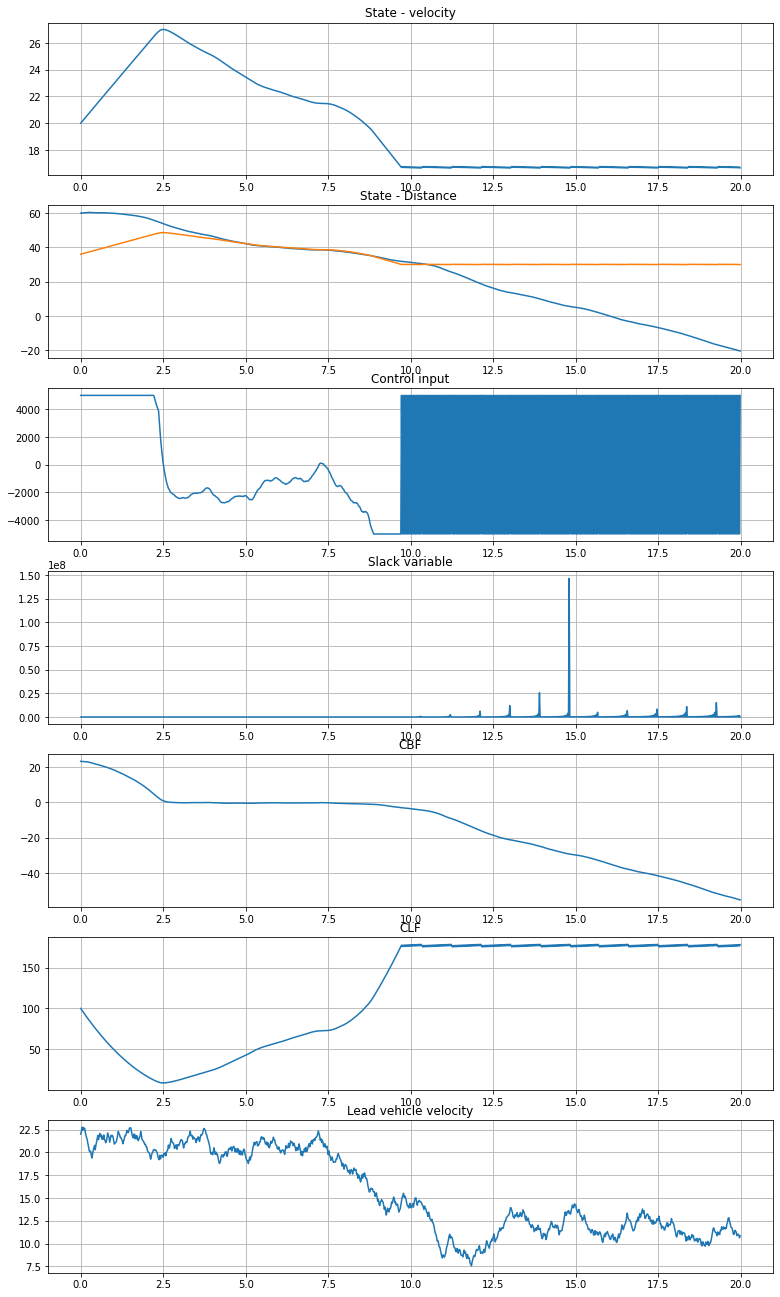

In [52]:
f,ax = plt.subplots(7,1,figsize = (13,23))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(x_lst)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[:,2])
ax[1].grid(True)
ax[1].set_title('State - Distance ')

ax[1].plot(t_lns, Th*np.array(x_lst)[:,1])

ax[2].plot(t_lns, np.array(u_lst))
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst))
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst))
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst))
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns, np.array(v_ego_lst))
ax[6].grid(True)
ax[6].set_title('Lead vehicle velocity')